# Introduction

The dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided(Source: UrbanSound8K.csv)

# Methodology Used 

There are 3 basic methods to extract features from audio file : 
a) Using the mffcs data of the audio files 
b) Using a spectogram image of the audio and then converting the same to data points (As is done for images). This is easily done using mel_spectogram function of Librosa 
c) Combining both features to build a better model. (Requires a lot of time to read and extract data).
We would go ahead withsecond Method.

The labels have been converted to categorical data for classification.(Csv File)

CNN has been used as the primary layer to classify data(Keras) 

# Importing Necessary Libraries

In [91]:
# Basic Libraries

import pandas as pd
import numpy as np

In [92]:
# Basic Libraries
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [93]:
# Basic Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [94]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [95]:
# Project Specific Libraries

import os
#pip install librosa
import librosa
import librosa.display
import glob 
import skimage

# Analysing Data Type and Format

In [96]:
#Analysing CSV Data

df = pd.read_csv('UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Description of Column Names:

slice_file_name: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav,where: 
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken 
[classID] = a numeric identifier of the sound class (see description of classID below for further details) [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

fsID: The Freesound ID of the recording from which this excerpt (slice) is taken

start The start time of the slice in the original Freesound recording

end: The end time of slice in the original Freesound recording

salience: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

fold: The fold number (1-10) to which this file has been allocated.

classID: A numeric identifier of the sound class: 0 = air_conditioner 1 = car_horn 2 = children_playing 3 = dog_bark 4 = drilling 5 = engine_idling 6 = gun_shot 7 = jackhammer 8 = siren 9 = street_music

class: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.

In [97]:
#Using Librosa to analyse random sound sample - SPECTOGRAM

dat1, sampling_rate1 = librosa.load('slice_file_name/fold5/6508-9-0-4.wav')
dat2, sampling_rate2 = librosa.load('slice_file_name/fold5/13577-3-5-0.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

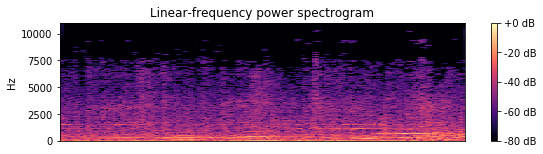

In [98]:
#Plot Linear frequency Power Spectrogram for Sample Random Data 1

plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

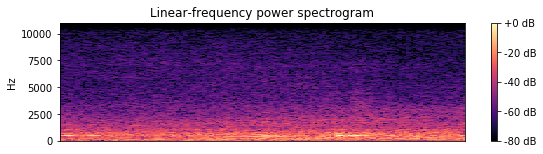

In [99]:
#Plot Linear frequency Power Spectrogram for Sample Random Data 2

plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Feature Extraction and Database Building

In [100]:
#Example 1

dat1, sampling_rate1 = librosa.load('slice_file_name/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [101]:
def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = 'slice_file_name/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [102]:
temp = parser(df)

/Users/hungerbox/opt/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/Users/hungerbox/opt/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/Users/hungerbox/opt/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [103]:
temp = np.array(temp)
data = temp.transpose()

In [104]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [105]:
for i in range(8732):
    X[i] = (X_[i])

In [107]:
Y = to_categorical(Y)

In [108]:
# Final Data 

print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [109]:
#Dividing into Training and Test set 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [110]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [111]:
input_dim = (16, 8, 1)

# Creating Keras Model and Testing

Model 1:
CNN 2D with 64 units and tanh activation.
MaxPool2D with 2*2 window.
CNN 2D with 128 units and tanh activation.
MaxPool2D with 2*2 window.
Dropout Layer with 0.2 drop probability.
DL with 1024 units and tanh activation.
DL 10 units with softmax activation.
Adam optimizer with categorical_crossentropy loss function.
90 epochs have been used.

In [112]:
model = Sequential()

In [113]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [114]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [116]:
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 4s 31ms/step - loss: 0.9803 - accuracy: 0.6683 - val_loss: 1.0717 - val_accuracy: 0.6468
Epoch 2/90
131/131 [==============================] - 4s 32ms/step - loss: 0.8269 - accuracy: 0.7236 - val_loss: 0.9779 - val_accuracy: 0.6913
Epoch 3/90
131/131 [==============================] - 4s 31ms/step - loss: 0.7465 - accuracy: 0.7520 - val_loss: 0.9036 - val_accuracy: 0.7302
Epoch 4/90
131/131 [==============================] - 4s 34ms/step - loss: 0.6908 - accuracy: 0.7703 - val_loss: 0.9144 - val_accuracy: 0.7407
Epoch 5/90
131/131 [==============================] - 5s 36ms/step - loss: 0.6350 - accuracy: 0.7908 - val_loss: 0.8873 - val_accuracy: 0.7187
Epoch 6/90
131/131 [==============================] - 5s 36ms/step - loss: 0.5787 - accuracy: 0.8071 - val_loss: 0.8050 - val_accuracy: 0.7595
Epoch 7/90
131/131 [==============================] - 4s 32ms/step - loss: 0.5405 - accuracy: 0.8252 - val_loss: 0.8779 - val_accuracy: 0.7444

Epoch 58/90
131/131 [==============================] - 4s 32ms/step - loss: 0.1003 - accuracy: 0.9673 - val_loss: 0.7952 - val_accuracy: 0.8502
Epoch 59/90
131/131 [==============================] - 4s 30ms/step - loss: 0.1041 - accuracy: 0.9661 - val_loss: 0.7600 - val_accuracy: 0.8594
Epoch 60/90
131/131 [==============================] - 4s 31ms/step - loss: 0.0897 - accuracy: 0.9693 - val_loss: 0.7634 - val_accuracy: 0.8575
Epoch 61/90
131/131 [==============================] - 4s 32ms/step - loss: 0.0968 - accuracy: 0.9667 - val_loss: 0.7975 - val_accuracy: 0.8534
Epoch 62/90
131/131 [==============================] - 4s 31ms/step - loss: 0.0808 - accuracy: 0.9705 - val_loss: 0.7268 - val_accuracy: 0.8672
Epoch 63/90
131/131 [==============================] - 5s 37ms/step - loss: 0.0737 - accuracy: 0.9766 - val_loss: 0.7120 - val_accuracy: 0.8621
Epoch 64/90
131/131 [==============================] - 4s 32ms/step - loss: 0.0616 - accuracy: 0.9783 - val_loss: 0.7481 - val_accuracy:

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [118]:
#Prediction

predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 6ms/step - loss: 0.8571 - accuracy: 0.8667
[0.8570606112480164, 0.8666971921920776]


In [119]:
preds = np.argmax(predictions, axis = 1)

In [120]:
# Moving the Predicted Data to a CSV file.

result = pd.DataFrame(preds)
result.to_csv("UrbanSound8kResults1.csv")